# Version Control

In [1]:
import sys
import conda
import requests
import pandas
import matplotlib
import numpy
import pytz
import pandas_market_calendars
import statsmodels.api

print("Conda version:", conda.__version__)
print("Python version:", sys.version)

print("\nrequests version:", requests.__version__)
print("pandas version:", pandas.__version__)
print("matplotlib version:", matplotlib.__version__)
print("numpy version:", numpy.__version__)
print("pytz version:", pytz.__version__)
print("pandas_market_calendars version:", pandas_market_calendars.__version__)
print("statsmodels version:", statsmodels.__version__)

Conda version: 23.5.2
Python version: 3.10.12 (main, Jul  5 2023, 15:02:25) [Clang 14.0.6 ]

requests version: 2.29.0
pandas version: 1.5.3
matplotlib version: 3.7.1
numpy version: 1.22.3
pytz version: 2022.7
pandas_market_calendars version: 4.1.4
statsmodels version: 0.14.0


In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pytz import timezone
import pandas_market_calendars as mcal
import statsmodels.api as sm
from code import POLYGON_API_KEY

In [3]:
plt.rcParams['figure.dpi'] = 150 # default DPI is 100, lower if plots are taking way too long

# Calculating n trading days ago
In this analysis, we will only be looking at the past 30 trading days. Choosing this over, say 252 trading days, offers us more recent changes in volatility.

In [4]:
days_back = 30

nyse = mcal.get_calendar('NYSE') # NYSE calendar
today = pd.Timestamp.today() # today's date for specific format for the code below
start_date = today - pd.DateOffset(months=3) # Go back 3 months to be safe
schedule = nyse.schedule(start_date=start_date, end_date=today)

# Check if today is a weekend
if today.weekday() >= 5: # This means if it's either Saturday (5) or Sunday (6)
    last_n_trading_dates = mcal.date_range(schedule, frequency='1D').date[-days_back:] # get n days back
else:
    last_n_trading_dates = mcal.date_range(schedule, frequency='1D').date[-1-days_back:] # get n days back

date_n_days_ago = last_n_trading_dates[0]
today_date = today.date() # now we can just use the YYYY-MM-DD format

print(f"Today's date: {today_date}")
print(f"{days_back} Trading days ago: {date_n_days_ago}")

Today's date: 2023-08-19
30 Trading days ago: 2023-07-10


# Pulling data from Polygon.io API
Polygon.io's API has a free tier that you offers up to two years worth of historical data. The only downside is that you cannot make large requests, but since we are only looking at 30 days worth of data, that's not an issue.

In [5]:
pull_request_url = f"https://api.polygon.io/v2/aggs/ticker/SPY/range/30/minute/{date_n_days_ago}/{today_date}?adjusted=true&sort=asc&limit=50000&apiKey={POLYGON_API_KEY}"
response = requests.get(pull_request_url)
if response.status_code == 200: # success status code
    data_json = response.json()
    print(data_json)
else:
    print("Request failed with status code:", response.status_code)
    exit()

{'ticker': 'SPY', 'queryCount': 24101, 'resultsCount': 960, 'adjusted': True, 'results': [{'v': 55286, 'vw': 437.3595, 'o': 437.14, 'c': 437.71, 'h': 437.86, 'l': 437.04, 't': 1688976000000, 'n': 323}, {'v': 17596, 'vw': 437.6025, 'o': 437.71, 'c': 437.54, 'h': 437.71, 'l': 437.46, 't': 1688977800000, 'n': 86}, {'v': 8135, 'vw': 437.7186, 'o': 437.56, 'c': 437.65, 'h': 437.88, 'l': 437.56, 't': 1688979600000, 'n': 46}, {'v': 5343, 'vw': 437.7286, 'o': 437.7, 'c': 437.65, 'h': 437.9, 'l': 437.59, 't': 1688981400000, 'n': 44}, {'v': 12441, 'vw': 437.6504, 'o': 437.64, 'c': 437.77, 'h': 437.8, 'l': 437.49, 't': 1688983200000, 'n': 70}, {'v': 18423, 'vw': 437.8757, 'o': 437.82, 'c': 438.13, 'h': 438.13, 'l': 437.72, 't': 1688985000000, 'n': 106}, {'v': 72021, 'vw': 438.3113, 'o': 438.15, 'c': 438.39, 'h': 438.46, 'l': 438.11, 't': 1688986800000, 'n': 546}, {'v': 105466, 'vw': 438.5086, 'o': 438.33, 'c': 438.69, 'h': 438.75, 'l': 438.27, 't': 1688988600000, 'n': 643}, {'v': 172050, 'vw': 43

In [6]:
data_df = pd.DataFrame(data_json["results"])
data_df.head()

,v,vw,o,c,h,l,t,n
0,55286.0,437.3595,437.14,437.71,437.86,437.04,1688976000000,323
1,17596.0,437.6025,437.71,437.54,437.71,437.46,1688977800000,86
2,8135.0,437.7186,437.56,437.65,437.88,437.56,1688979600000,46
3,5343.0,437.7286,437.70,437.65,437.90,437.59,1688981400000,44
4,12441.0,437.6504,437.64,437.77,437.80,437.49,1688983200000,70


# Getting cash session data only
As a futures trader and like most other traders, we thrive during peak volatility hours due to ease to capturing the trend. It is nice to know during which hours markets tend to be choppy. In this example, we will only be looking at the cash session of SPY (which is useful for ES derivatives traders (me) and SPY/SPX options traders).

In [7]:
start_time = pd.to_datetime('8:30:00').time() # cash session open
end_time = pd.to_datetime('14:30:00').time() # cash session close

In [8]:
cash_session_df = data_df.copy()

### Convert from Unix Timestamp to regular time

In [9]:
central = timezone('America/Chicago') # Define UTC and Central Time timezones

cash_session_df['Time'] = pd.to_datetime(cash_session_df['t'], unit='ms', utc=True) # Convert Unix timestamps to datetime in UTC

cash_session_df['Time'] = cash_session_df['Time'].dt.tz_convert(central) # Convert UTC datetime to Central Time

cash_session_df['Time'] = cash_session_df['Time'].dt.time # If you want only the time part in CT

cash_session_df.head()

,v,vw,o,c,h,l,t,n,Time
0,55286.0,437.3595,437.14,437.71,437.86,437.04,1688976000000,323,03:00:00
1,17596.0,437.6025,437.71,437.54,437.71,437.46,1688977800000,86,03:30:00
2,8135.0,437.7186,437.56,437.65,437.88,437.56,1688979600000,46,04:00:00
3,5343.0,437.7286,437.70,437.65,437.90,437.59,1688981400000,44,04:30:00
4,12441.0,437.6504,437.64,437.77,437.80,437.49,1688983200000,70,05:00:00


### Filter time for cash session hours

In [10]:
cash_session_df = cash_session_df[(cash_session_df['Time'] >= start_time) & (cash_session_df['Time'] <= end_time)] # filter only cash session
cash_session_df = cash_session_df.assign(Range=np.log(cash_session_df["h"]) - np.log(cash_session_df["l"])) # taking log diff to make data stationary
cash_session_df

,v,vw,o,c,h,l,t,n,Time,Range
11,5881917.0,438.9351,438.1800,439.0950,439.348,438.05,1688995800000,57103,08:30:00,0.002959
12,4206288.0,439.5368,439.0800,439.2699,439.840,439.03,1688997600000,43199,09:00:00,0.001843
13,4767076.0,438.7633,439.2700,438.6299,439.390,438.37,1688999400000,38002,09:30:00,0.002324
14,4792465.0,438.4163,438.6208,438.7200,438.780,438.01,1689001200000,29737,10:00:00,0.001756
15,2813182.0,438.6699,438.7099,438.4201,439.080,438.10,1689003000000,24264,10:30:00,0.002234
...,...,...,...,...,...,...,...,...,...,...
947,4824496.0,435.8824,435.5500,435.9050,436.085,435.16,1692379800000,29989,12:30:00,0.002123
948,4214842.0,436.0385,435.9100,435.9550,436.290,435.49,1692381600000,29999,13:00:00,0.001835
949,5511718.0,436.3459,435.9400,435.9300,436.760,435.88,1692383400000,38643,13:30:00,0.002017
950,4833699.0,435.8203,435.9600,436.1400,436.230,435.36,1692385200000,38274,14:00:00,0.001996


In [11]:
range_time_df = cash_session_df.copy()
range_time_df = range_time_df[["Time", "Range"]] # reduce the dataframe to what we need
range_time_df.head(20)

,Time,Range
11,08:30:00,0.002959
12,09:00:00,0.001843
13,09:30:00,0.002324
14,10:00:00,0.001756
15,10:30:00,0.002234
16,11:00:00,0.002043
17,11:30:00,0.001619
18,12:00:00,0.000843
19,12:30:00,0.001344
20,13:00:00,0.002028


### Bundle time intervals up

In [12]:
time_grouped_df = range_time_df.groupby("Time")["Range"].apply(list) # bundle all the 30min intervals together
time_grouped_df.head(13)

Time
08:30:00    [0.002958750639762364, 0.0031727166399191375, ...
09:00:00    [0.0018432765467988332, 0.0021935690648797745,...
09:30:00    [0.0023240987493666765, 0.0017257043338103628,...
10:00:00    [0.0017564073448648188, 0.0012707347009364156,...
10:30:00    [0.0022344339992628193, 0.0025060822432809715,...
11:00:00    [0.002043228096931138, 0.0028339870466762562, ...
11:30:00    [0.0016186951382772818, 0.001335584448615812, ...
12:00:00    [0.0008426833366144137, 0.0016554605619880647,...
12:30:00    [0.001343642383403676, 0.0012363955544829608, ...
13:00:00    [0.002027679039474428, 0.0019759237879100056, ...
13:30:00    [0.0015486401254927173, 0.0024495362667735776,...
14:00:00    [0.0011615593530382995, 0.0011668546664171942,...
14:30:00    [0.0024138099801254143, 0.0040264259970932414,...
Name: Range, dtype: object

# PRE-BOOTSTRAP
Our data does not appear to come from any specific distribution, which makes visualizing and interpreting the data less simple. As you can see, the histograms are lackluster, and doing an analysis just on this would have too many holes in the data. In the next step, we will perform a bootstrap sampling technique.

In [13]:
Times = ['08:30:00', '09:00:00', '09:30:00', '10:00:00', '10:30:00', '11:00:00', '11:30:00', '12:00:00', '12:30:00', '13:00:00', '13:30:00', '14:00:00', '14:30:00']
colors = plt.cm.tab20(np.linspace(0, 1, 13)) # colors of histogram

# Pre-Bootstrap Histograms of Each Time

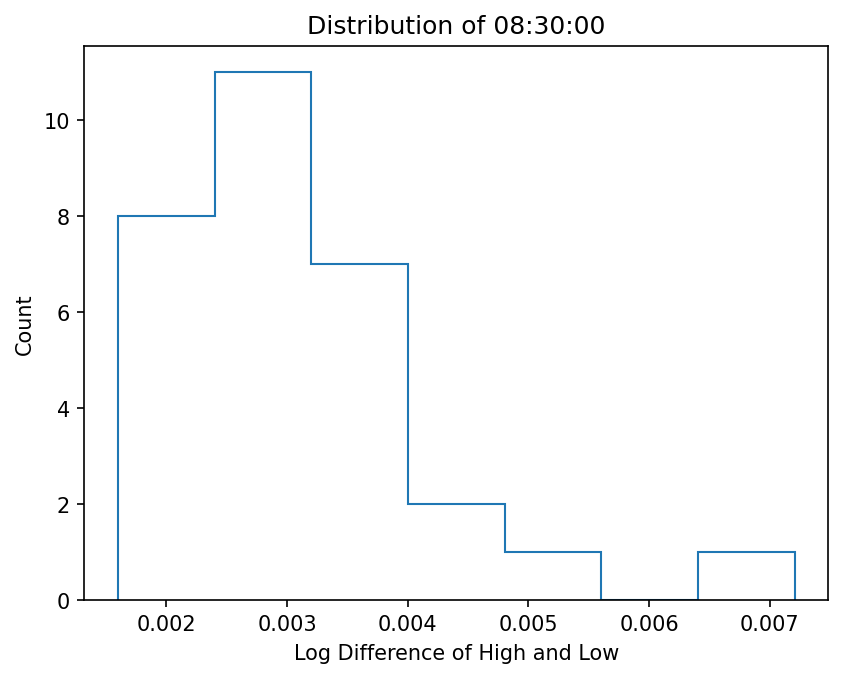

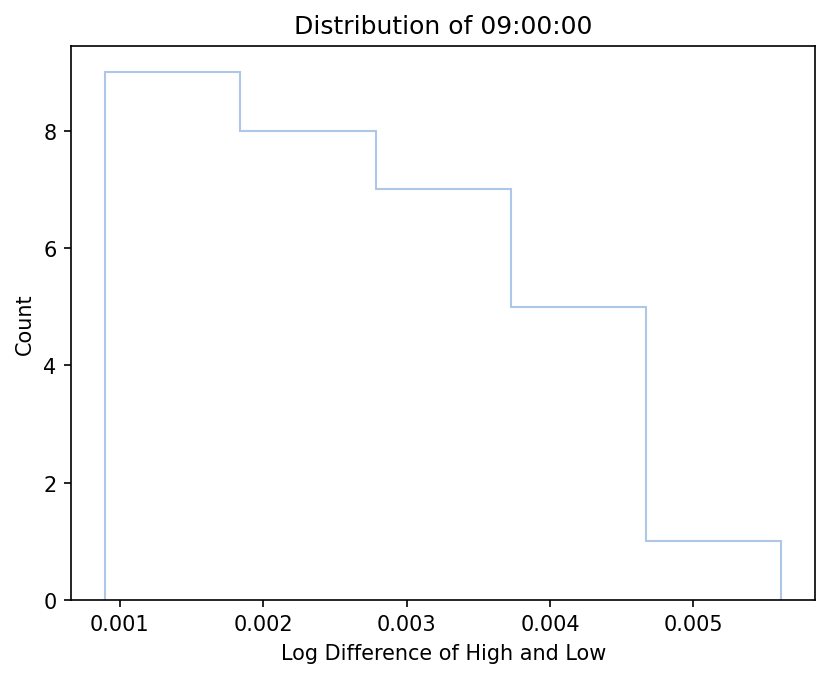

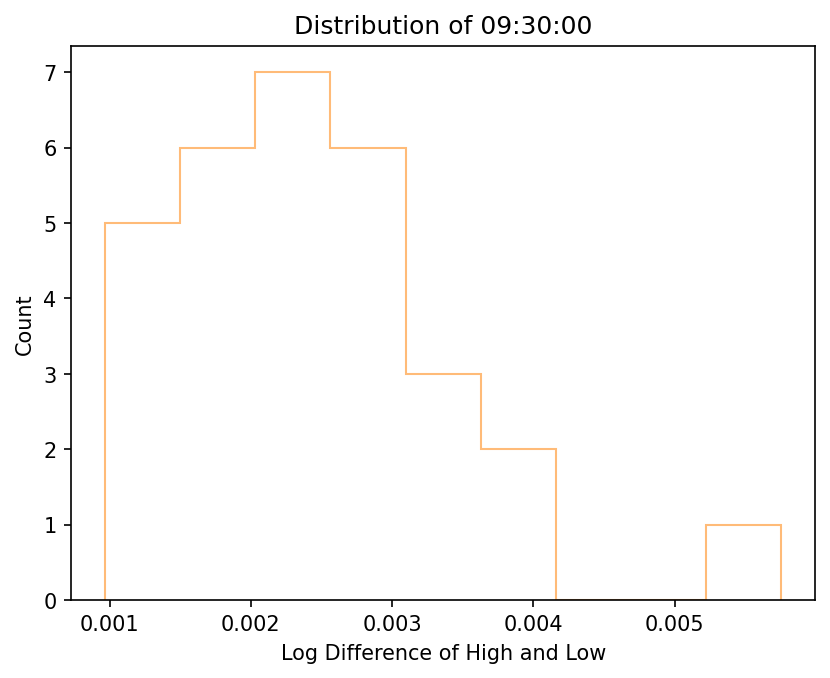

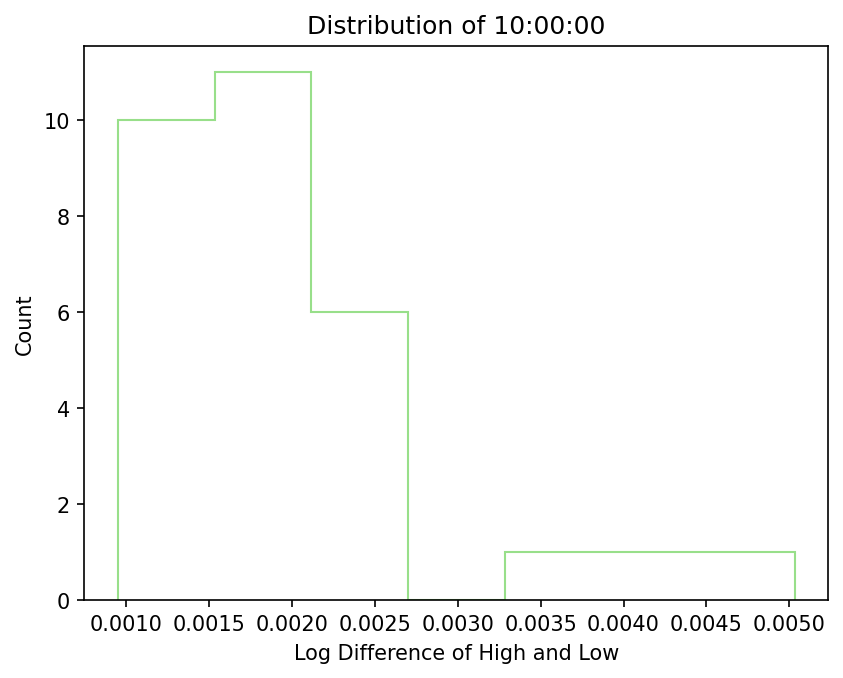

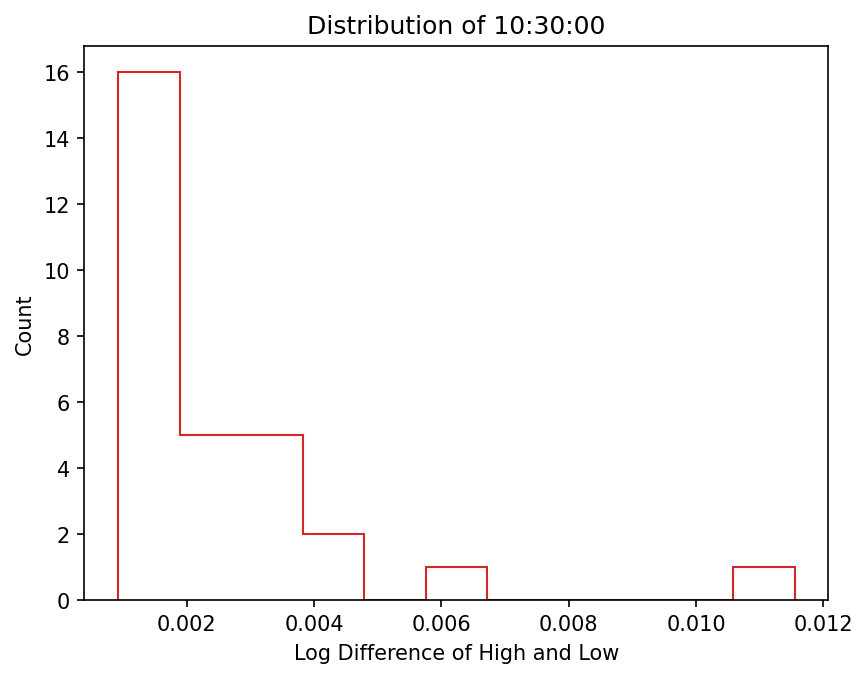

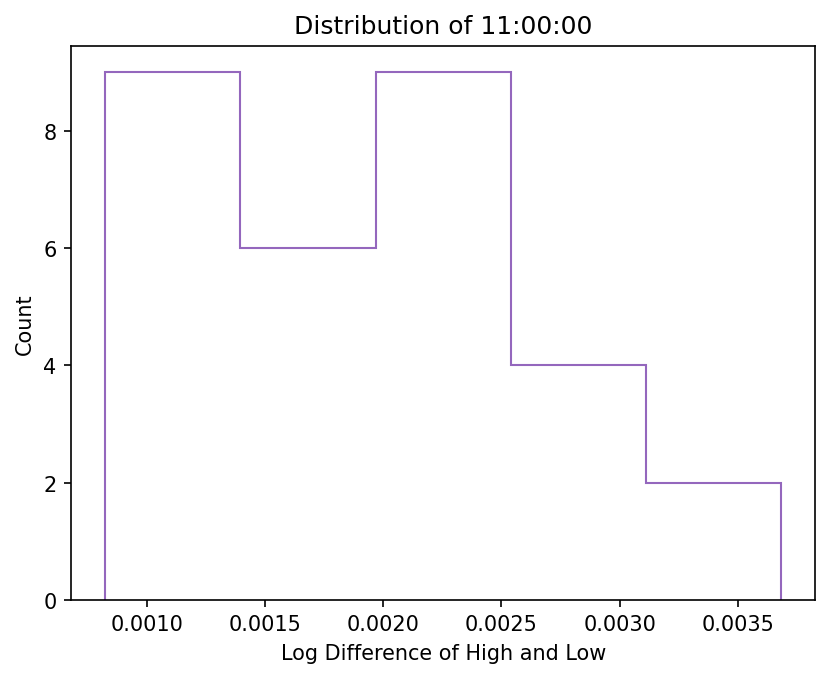

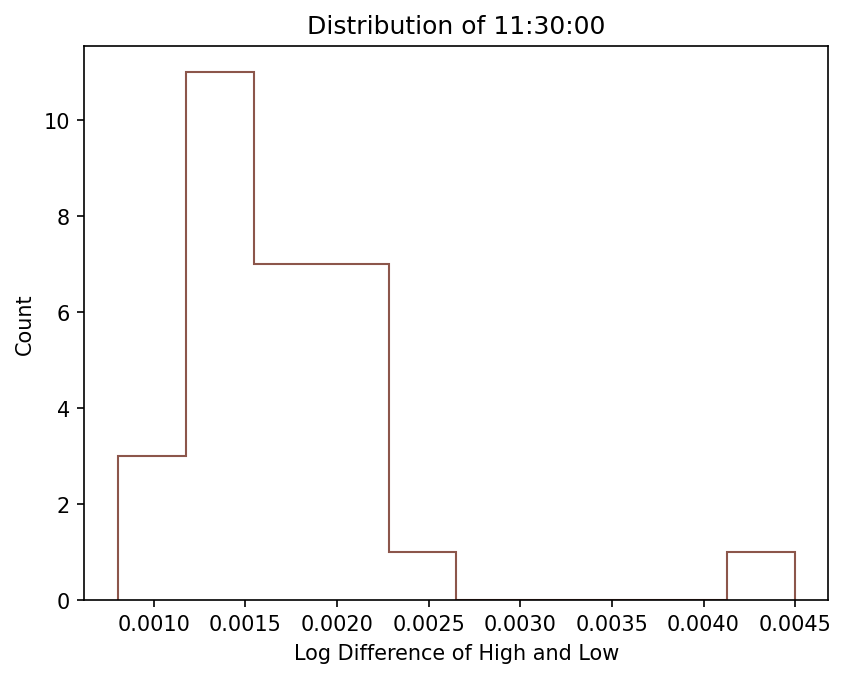

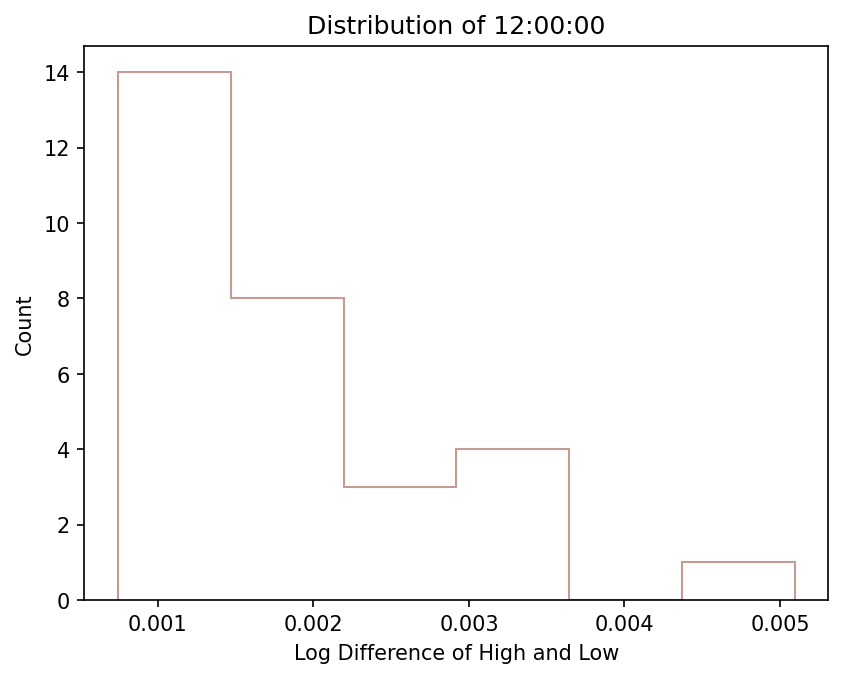

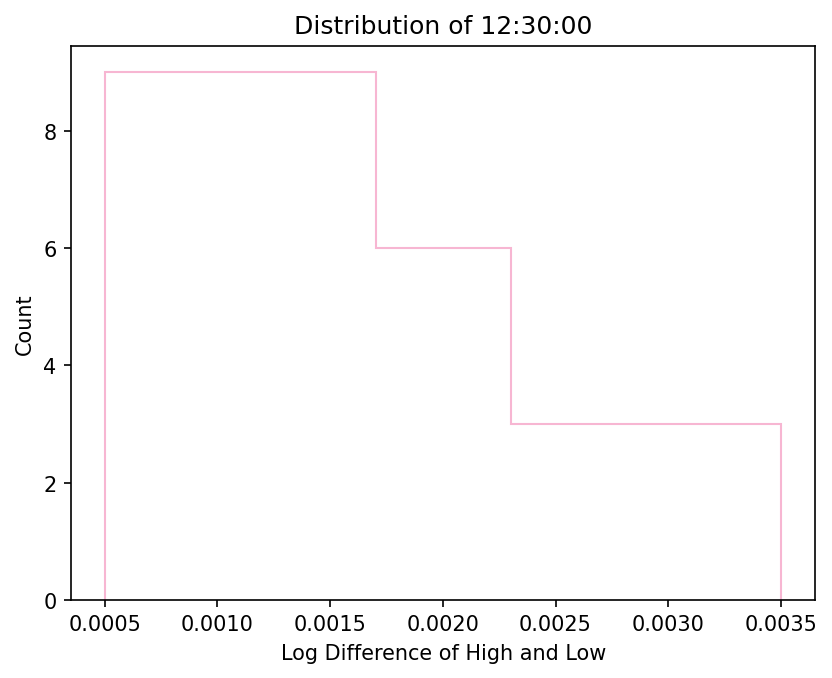

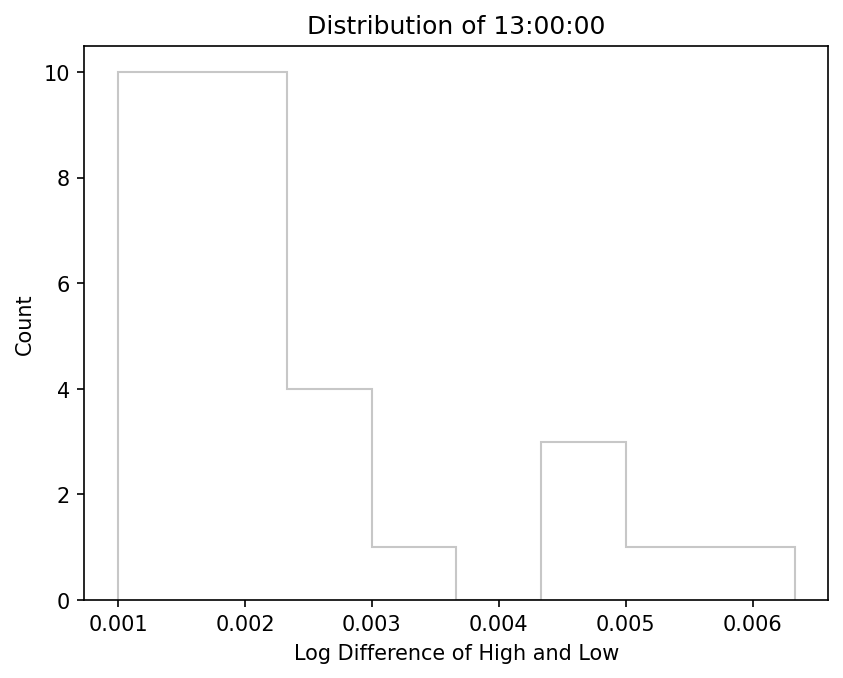

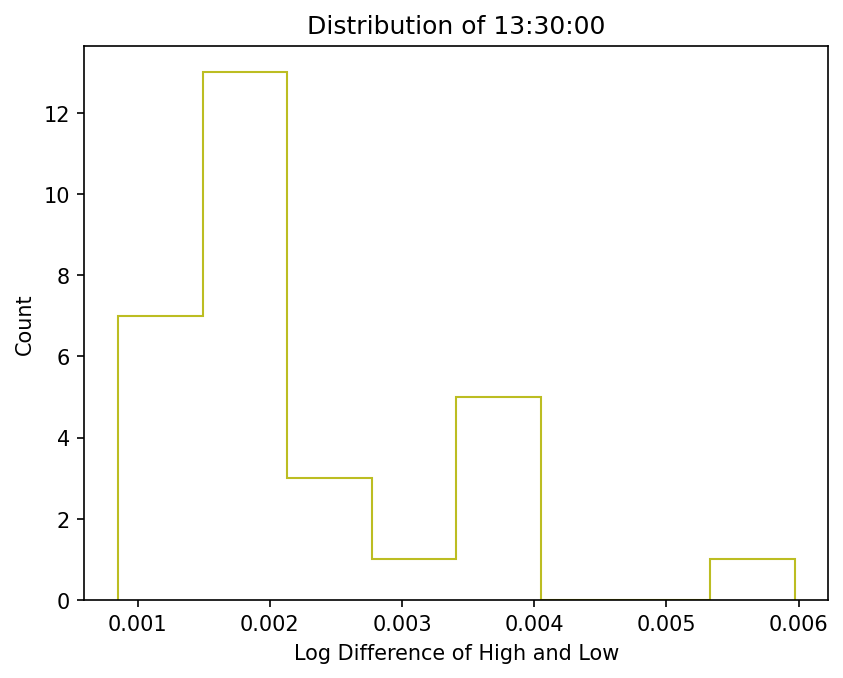

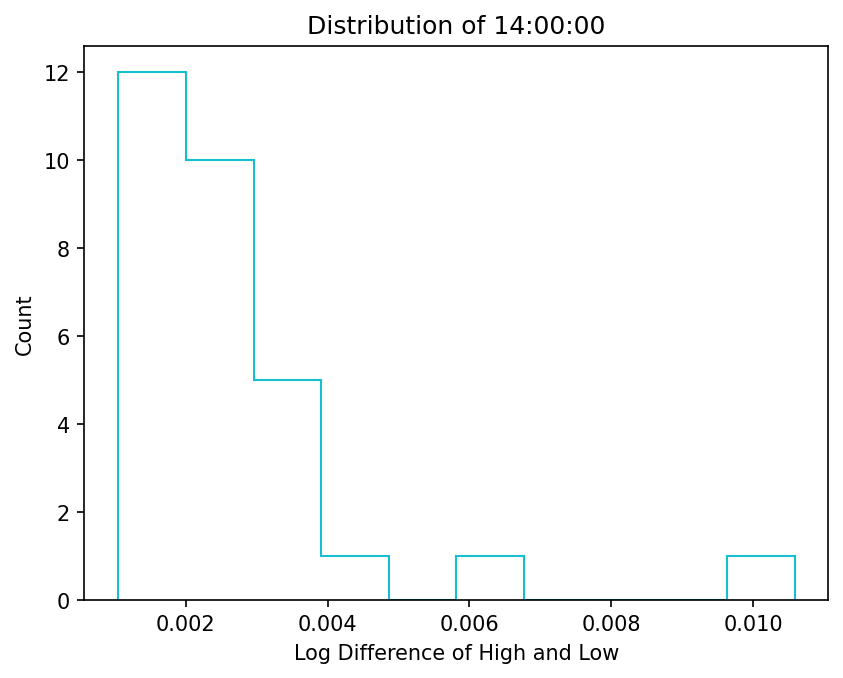

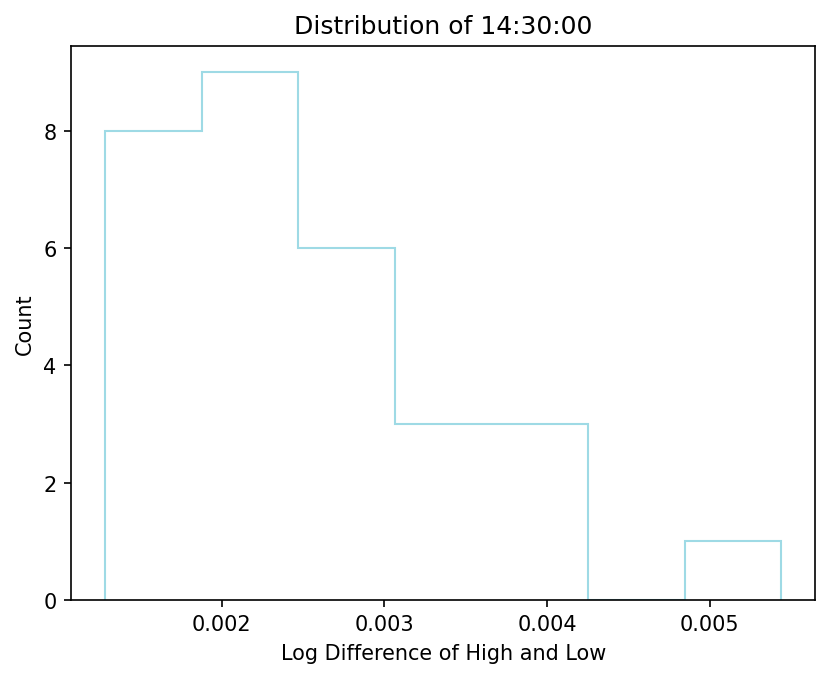

In [14]:
for i in range(time_grouped_df.shape[0]):
    plt.hist(time_grouped_df[i], bins='fd', histtype='step', fill=False, alpha=1, color=colors[i])
    plt.title(f"Distribution of {Times[i]}")
    plt.xlabel("Log Difference of High and Low")
    plt.ylabel("Count")
    plt.show()

# BOOTSTRAP TIME
The idea behind bootstrapping is simple: use your sample as a proxy for the population, so sample from it with replacement so simulate different samples. This approach makes little assumptions, especially about the distribution of the data, so it is a robust technique. I am bootstrap sampling from each time and calculating the mean of that sample. Due to the Central Limit Theorem, the means will converge to a Gaussian distribution. That makes visualizing and interpreting the data MUCH easier.

In [15]:
n_samples = 10000000 # times we will bootstrap sample from our data
resampled_data = []
time_mean = np.array([])
time_stddev = np.array([])

for time, data_points in time_grouped_df.items():
    bootstrap_means = []

    bootstrap_samples = np.random.choice(data_points, size=(n_samples, len(data_points)), replace=True) # bootstrap
    sample_mean = np.mean(bootstrap_samples, axis=1)

    time_mean = np.append(time_mean, np.mean(bootstrap_samples))
    time_stddev = np.append(time_stddev, np.std(bootstrap_samples))

    bootstrap_means.append(sample_mean)
    resampled_data.append((time, bootstrap_means))

bootstrapped_time_grouped_df = pd.DataFrame(resampled_data, columns=['Time', 'ResampledData']) # dataframe with the bootstrapped data
bootstrapped_time_grouped_df.head(13)

,Time,ResampledData
0,08:30:00,"[[0.0028668146318239886, 0.003384926400580094,..."
1,09:00:00,"[[0.0028887375139016254, 0.002672004756165247,..."
2,09:30:00,"[[0.0020721612819590025, 0.002482153166286594,..."
3,10:00:00,"[[0.0021073797737092724, 0.0017267048978811595..."
4,10:30:00,"[[0.0024561140976200766, 0.002518024549396151,..."
5,11:00:00,"[[0.002271604828235585, 0.0017969509251191636,..."
6,11:30:00,"[[0.001715644625438273, 0.0017752607870606654,..."
7,12:00:00,"[[0.0019197386734503218, 0.0016326133182305172..."
8,12:30:00,"[[0.0015192760426972819, 0.0018270316460141877..."
9,13:00:00,"[[0.0022770660381819853, 0.002602556804158714,..."


### Q-Q Plot Test for Normality
<center>
A Q-Q plot (Quantile-Quantile plot) is a graphical tool used to assess whether a dataset follows a specific theoretical distribution, such as the normal distribution. It compares the quantiles of the observed data against the quantiles expected from the theoretical distribution, and if the points lie approximately along a straight line, it suggests that the data is consistent with the assumed distribution.
</center>

<Figure size 450x450 with 0 Axes>

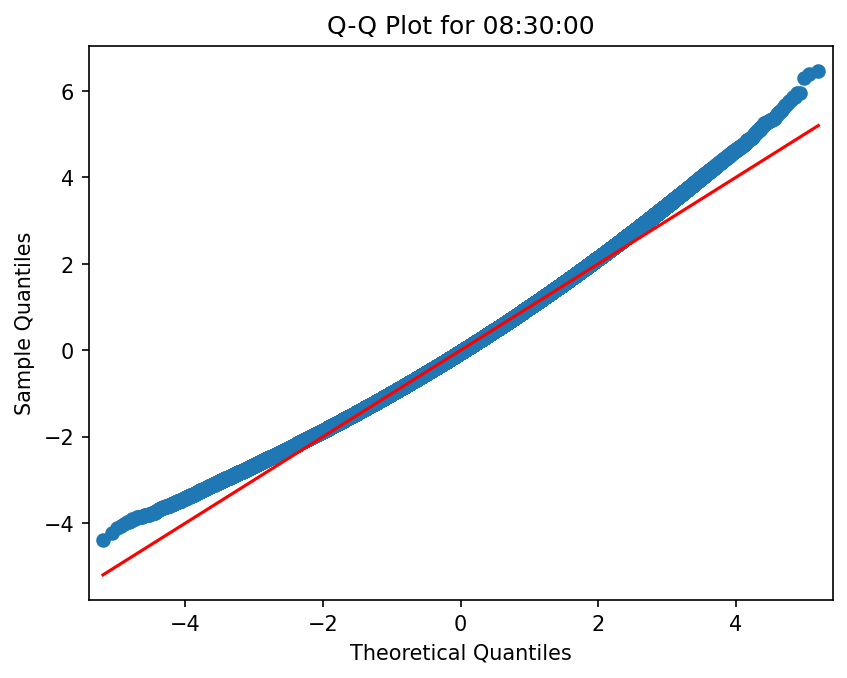

<Figure size 450x450 with 0 Axes>

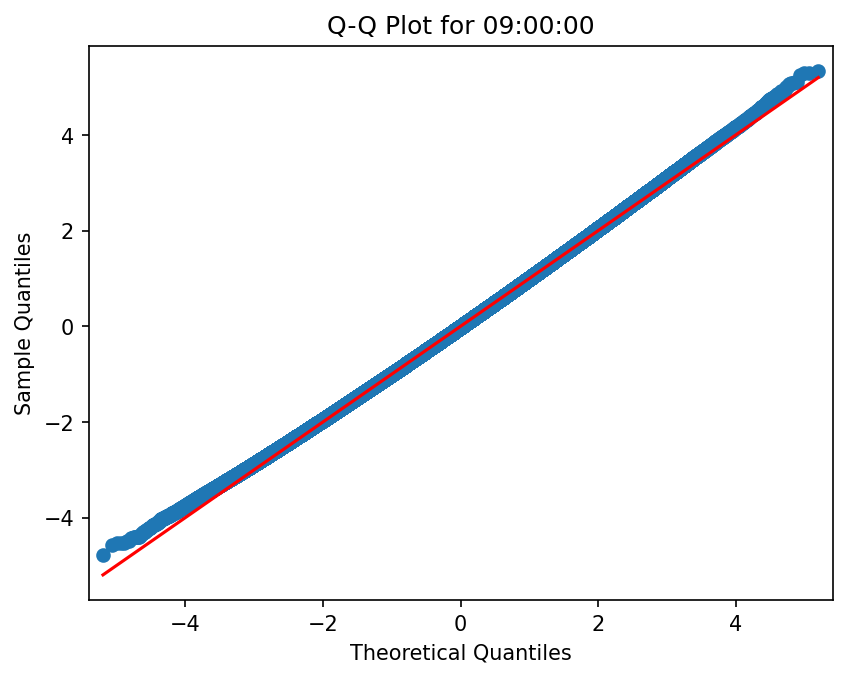

<Figure size 450x450 with 0 Axes>

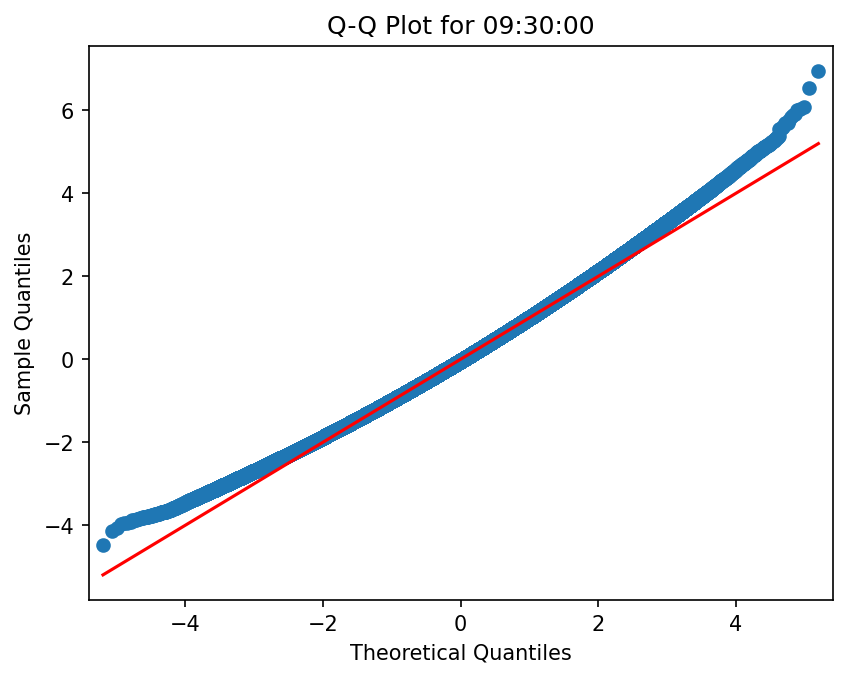

<Figure size 450x450 with 0 Axes>

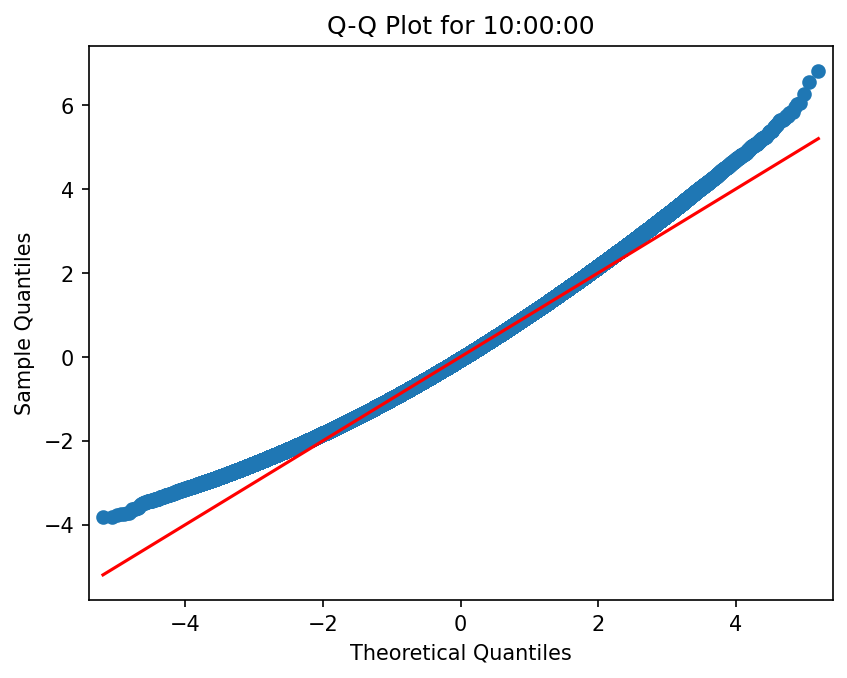

<Figure size 450x450 with 0 Axes>

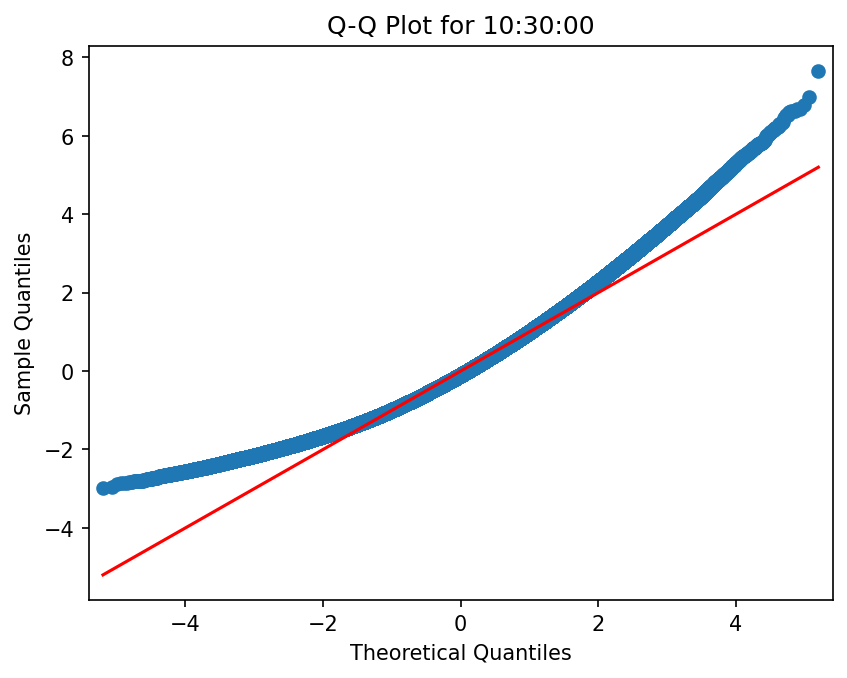

<Figure size 450x450 with 0 Axes>

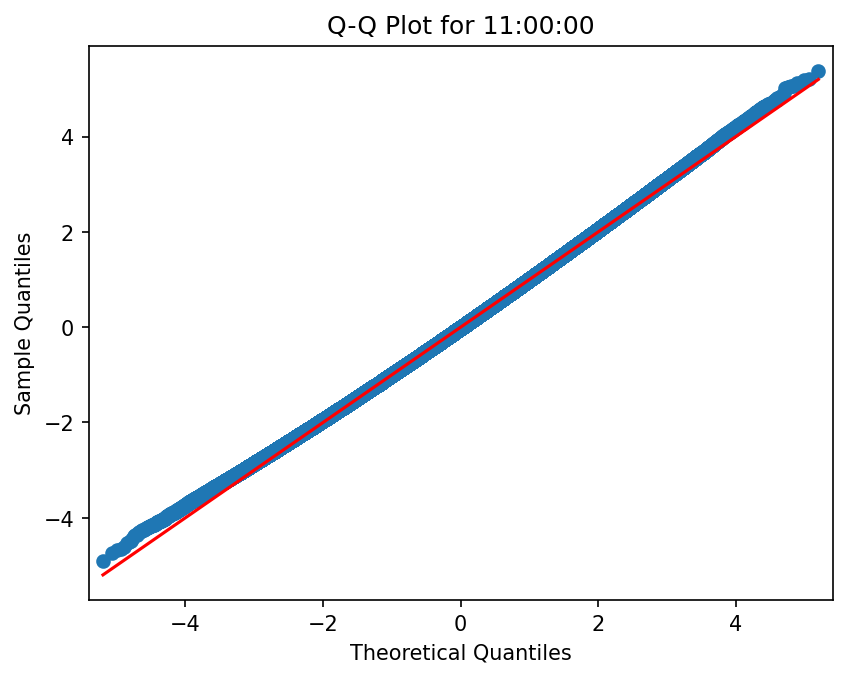

<Figure size 450x450 with 0 Axes>

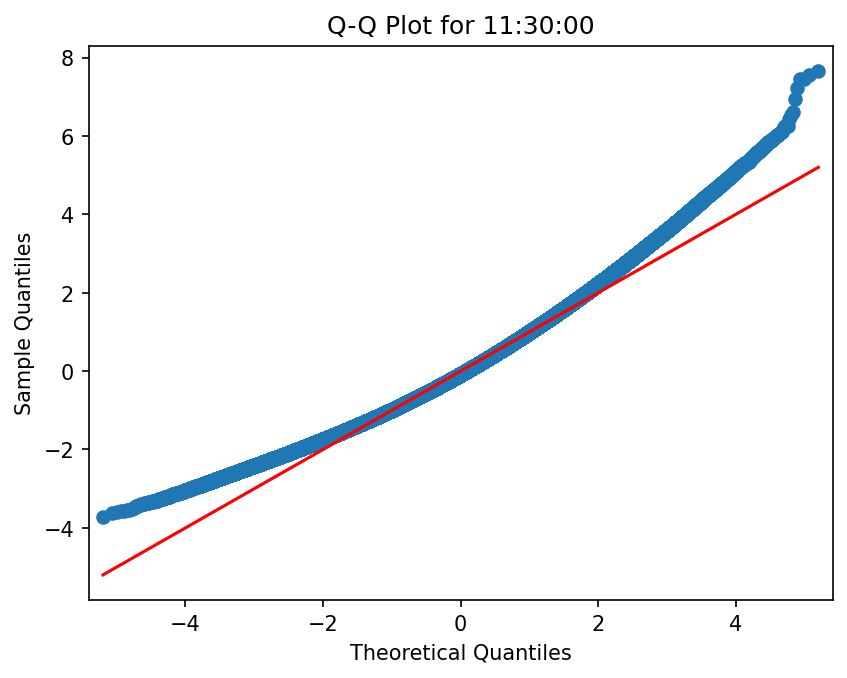

<Figure size 450x450 with 0 Axes>

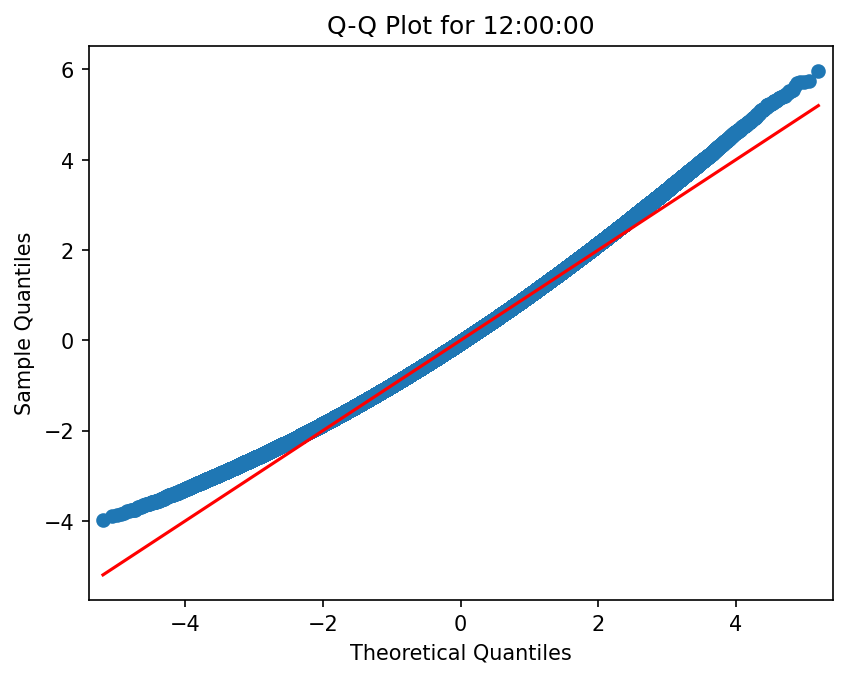

<Figure size 450x450 with 0 Axes>

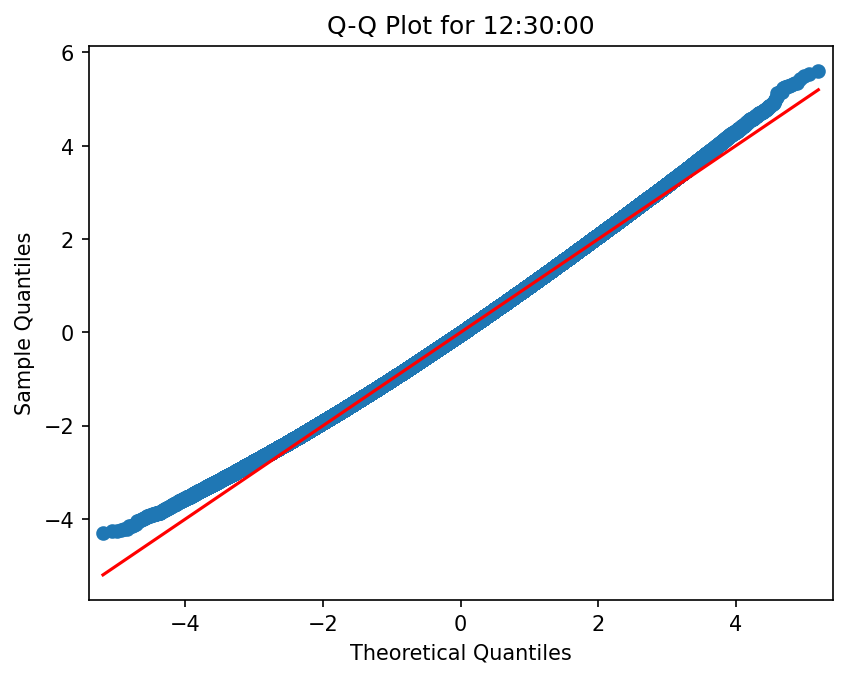

<Figure size 450x450 with 0 Axes>

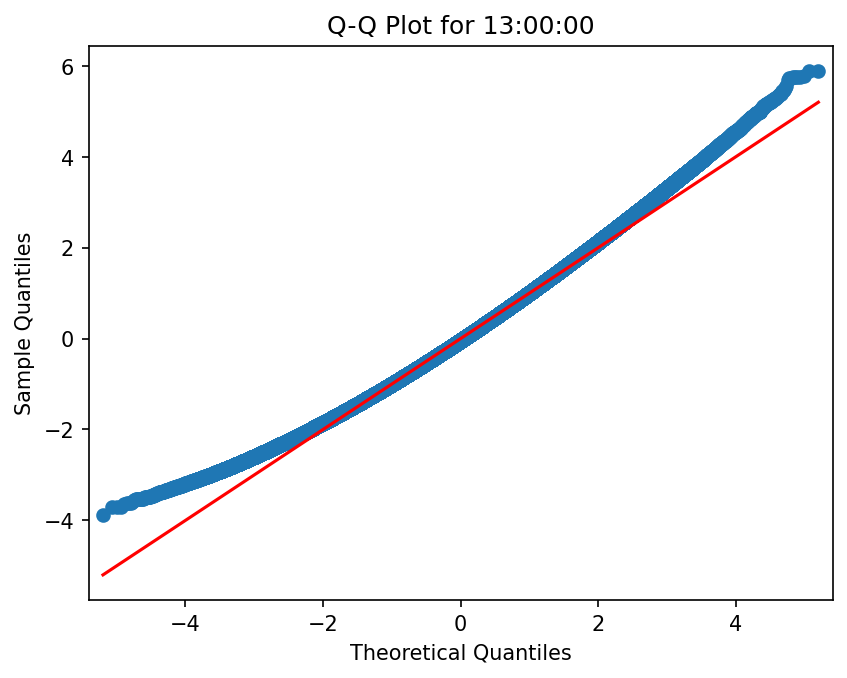

<Figure size 450x450 with 0 Axes>

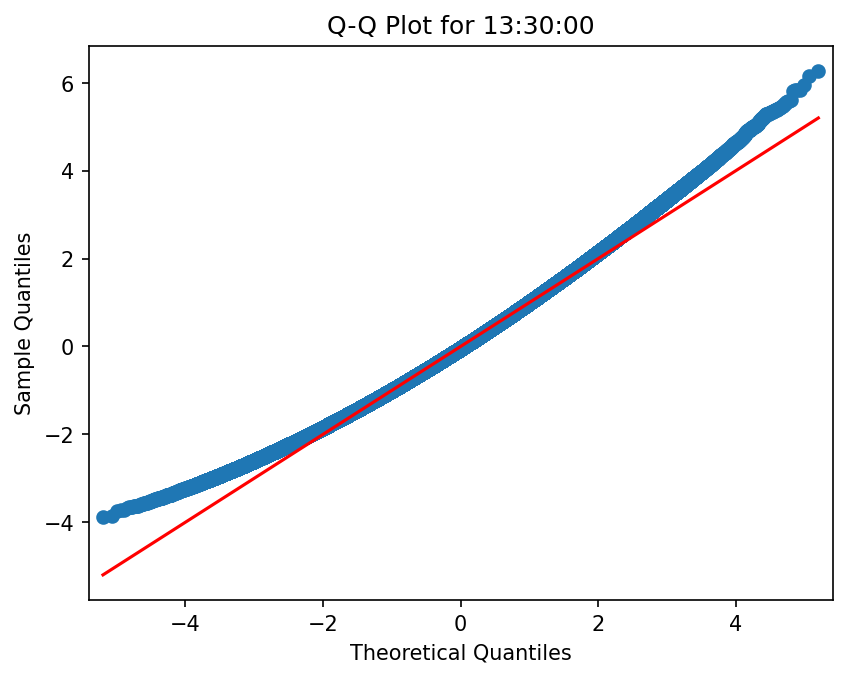

<Figure size 450x450 with 0 Axes>

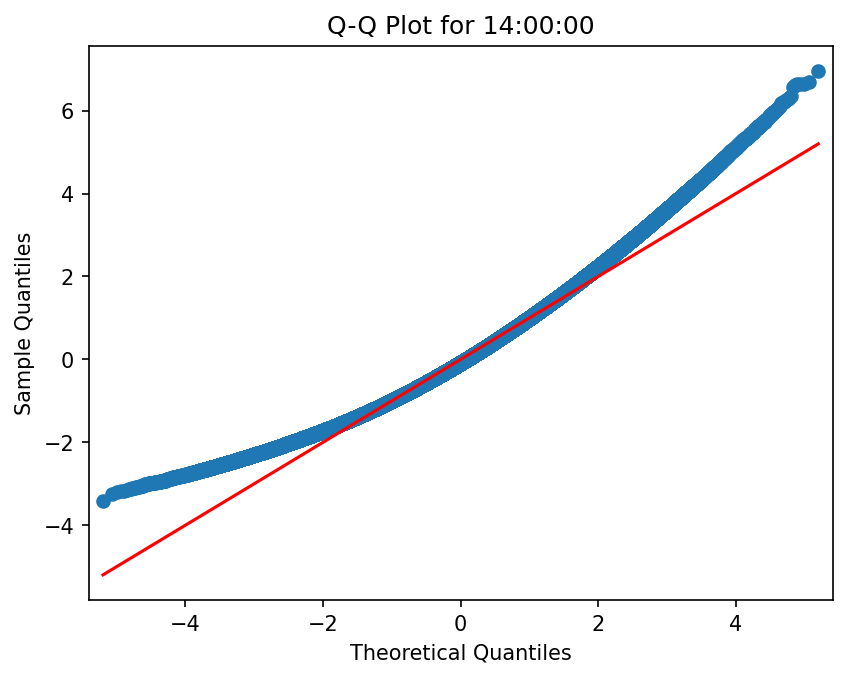

<Figure size 450x450 with 0 Axes>

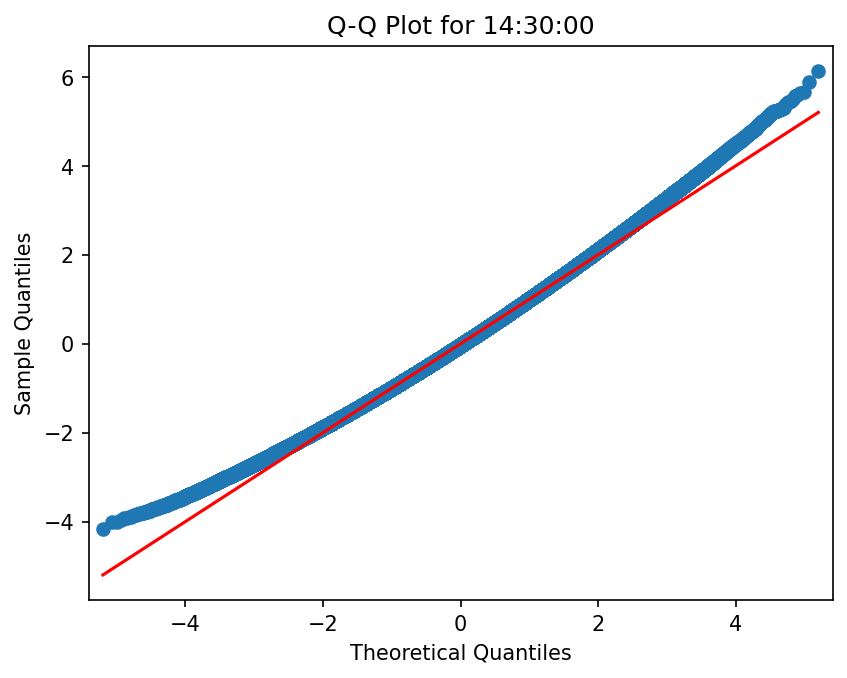

In [16]:
for i in range(bootstrapped_time_grouped_df.shape[0]):
    plt.figure(figsize=(3, 3))
    sm.qqplot(bootstrapped_time_grouped_df.iloc[i,1][0], line='s', fit=True)

    plt.title(f"Q-Q Plot for {Times[i]}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

## Notice, some Q-Q plots display slight skewness that we can observe in the histograms and box plots below. An important detail to remember is important financial or economic data is typically released 11am - 1pm CT. That heavily contributes to fatter distribution tails. However, for this analysis, we can assume normality for all the distributions due to the majority of our data being normally distributed.

### Histograms of the bootstrapped data

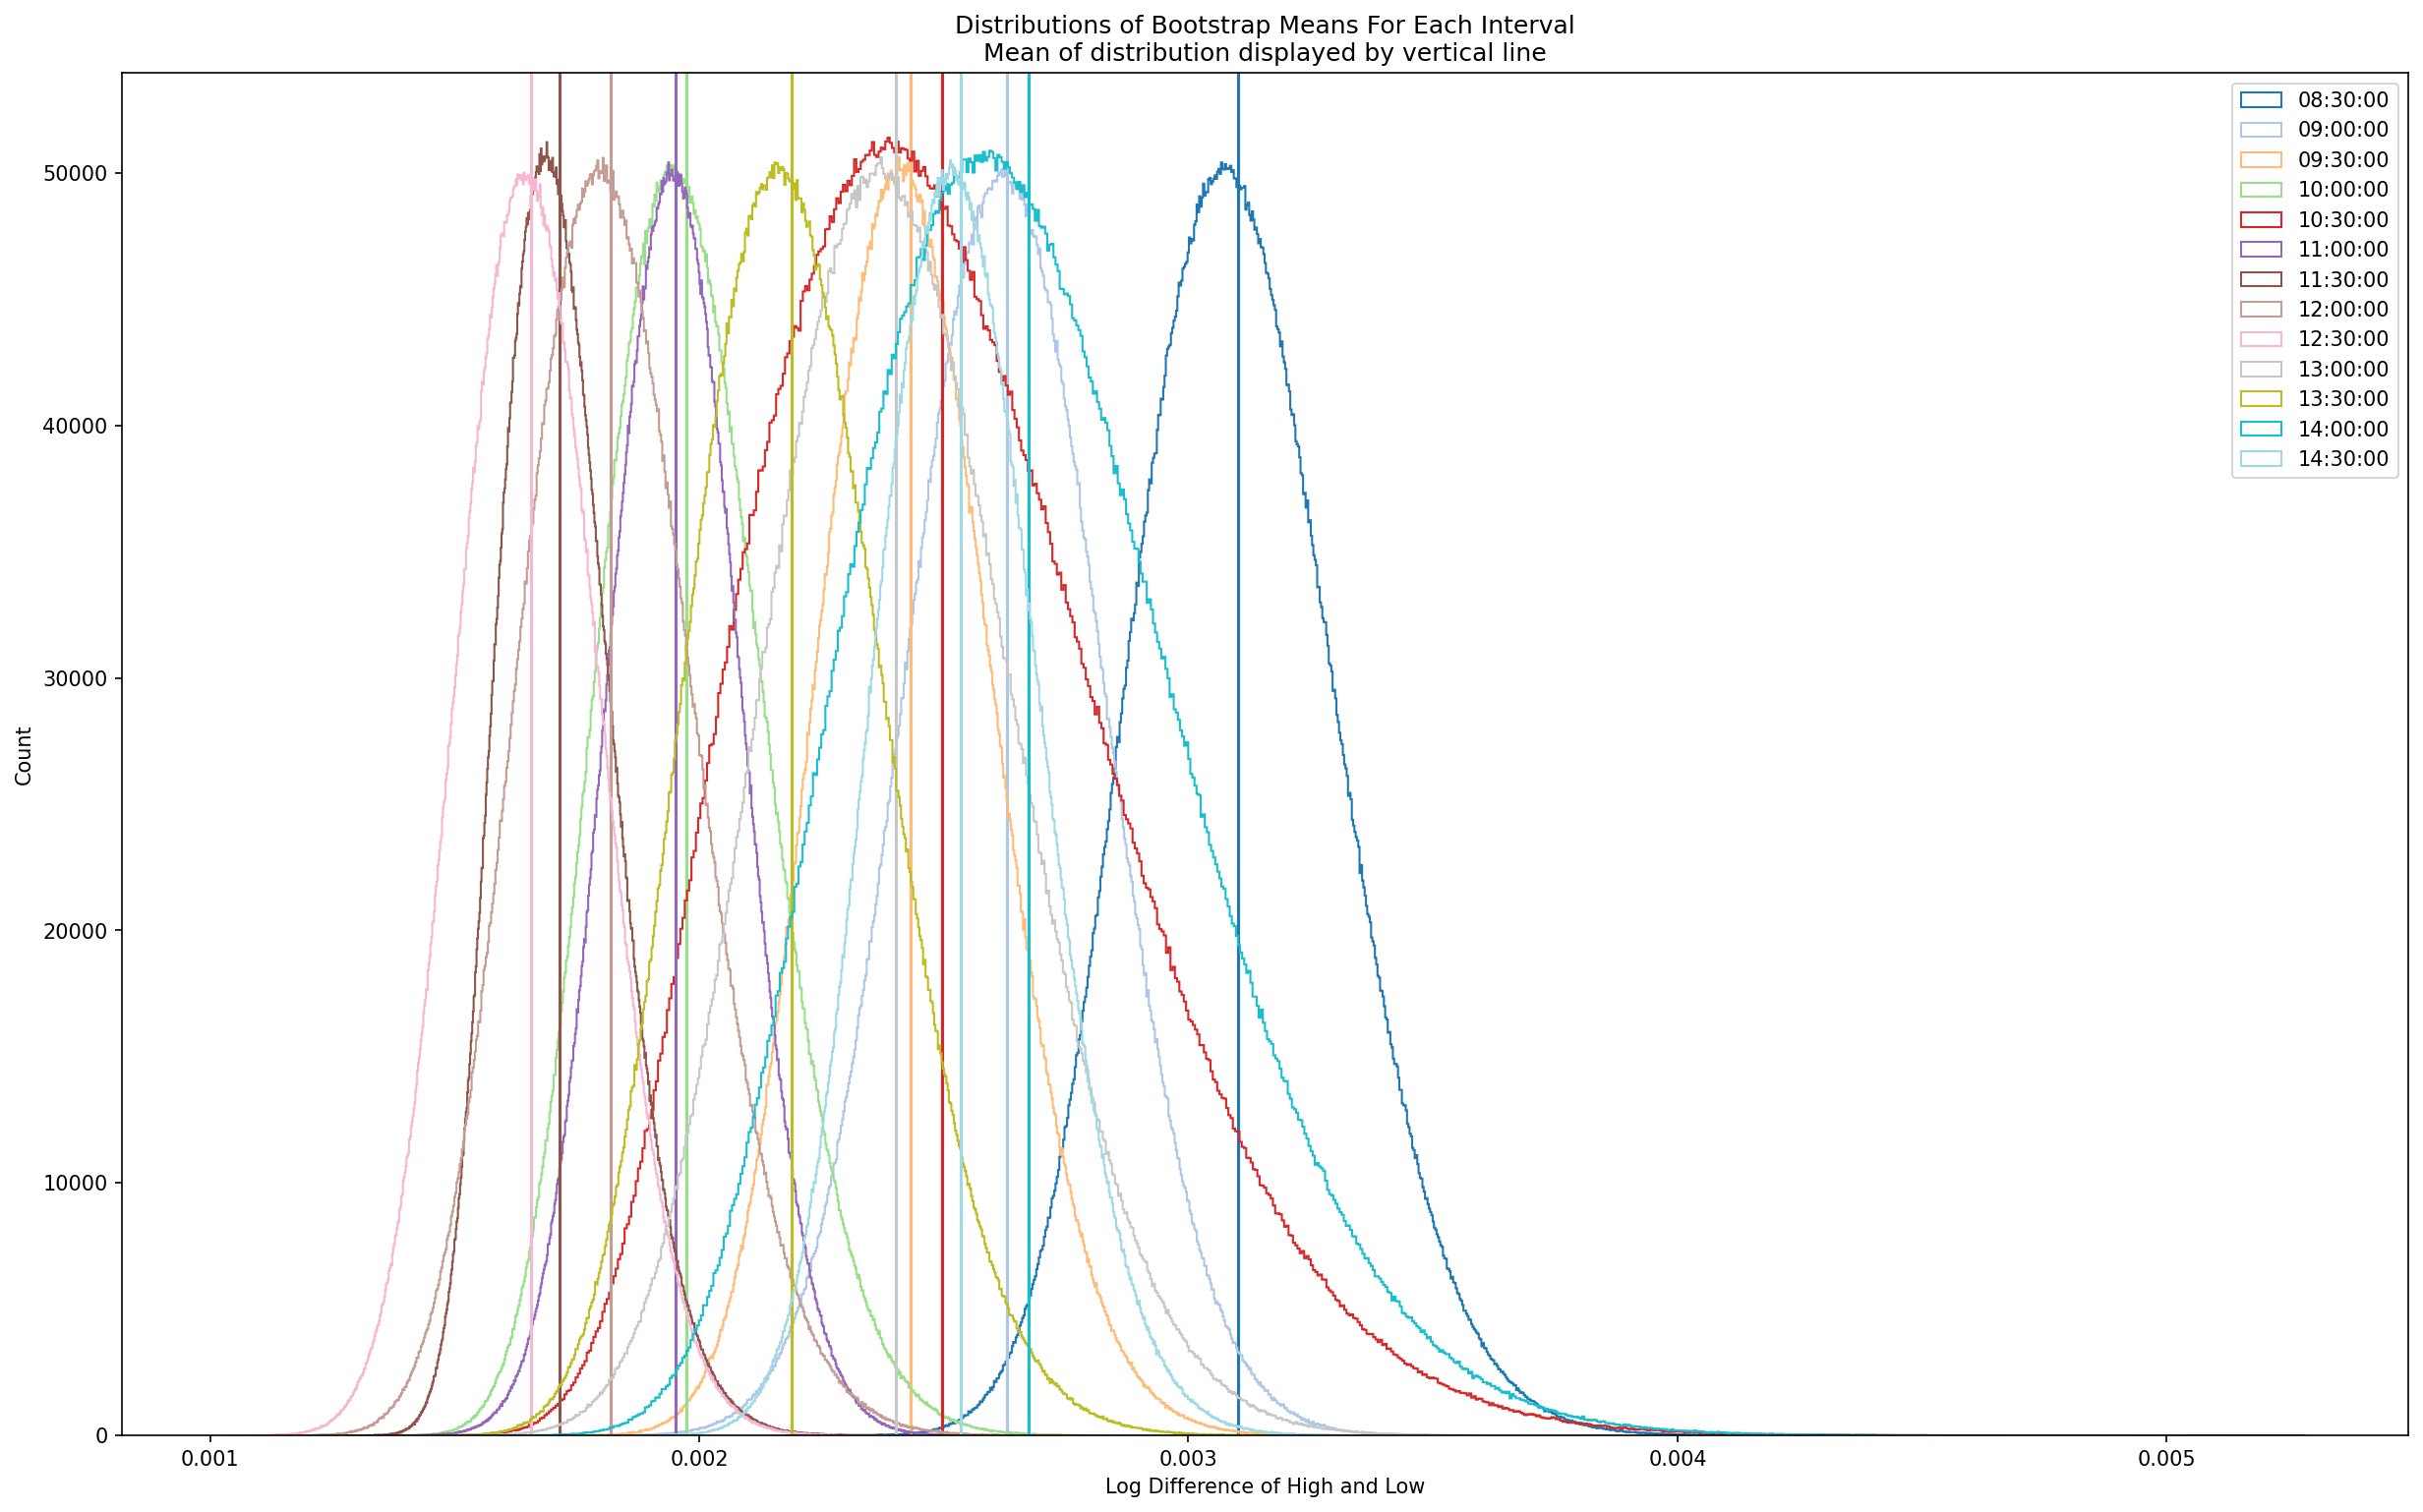

In [17]:
plt.figure(figsize=(20, 12))
for i in range(bootstrapped_time_grouped_df.shape[0]):
    plt.hist(bootstrapped_time_grouped_df.iloc[i,1], bins='fd', label=f"{Times[i]}", histtype='step', alpha=1, color=colors[i])
    plt.axvline(x=time_mean[i], color=colors[i])

plt.title(f"Distributions of Bootstrap Means For Each Interval\nMean of distribution displayed by vertical line")
plt.xlabel("Log Difference of High and Low")
plt.ylabel("Count")
plt.legend()
plt.show()

### Box Plot of the bootstrapped data

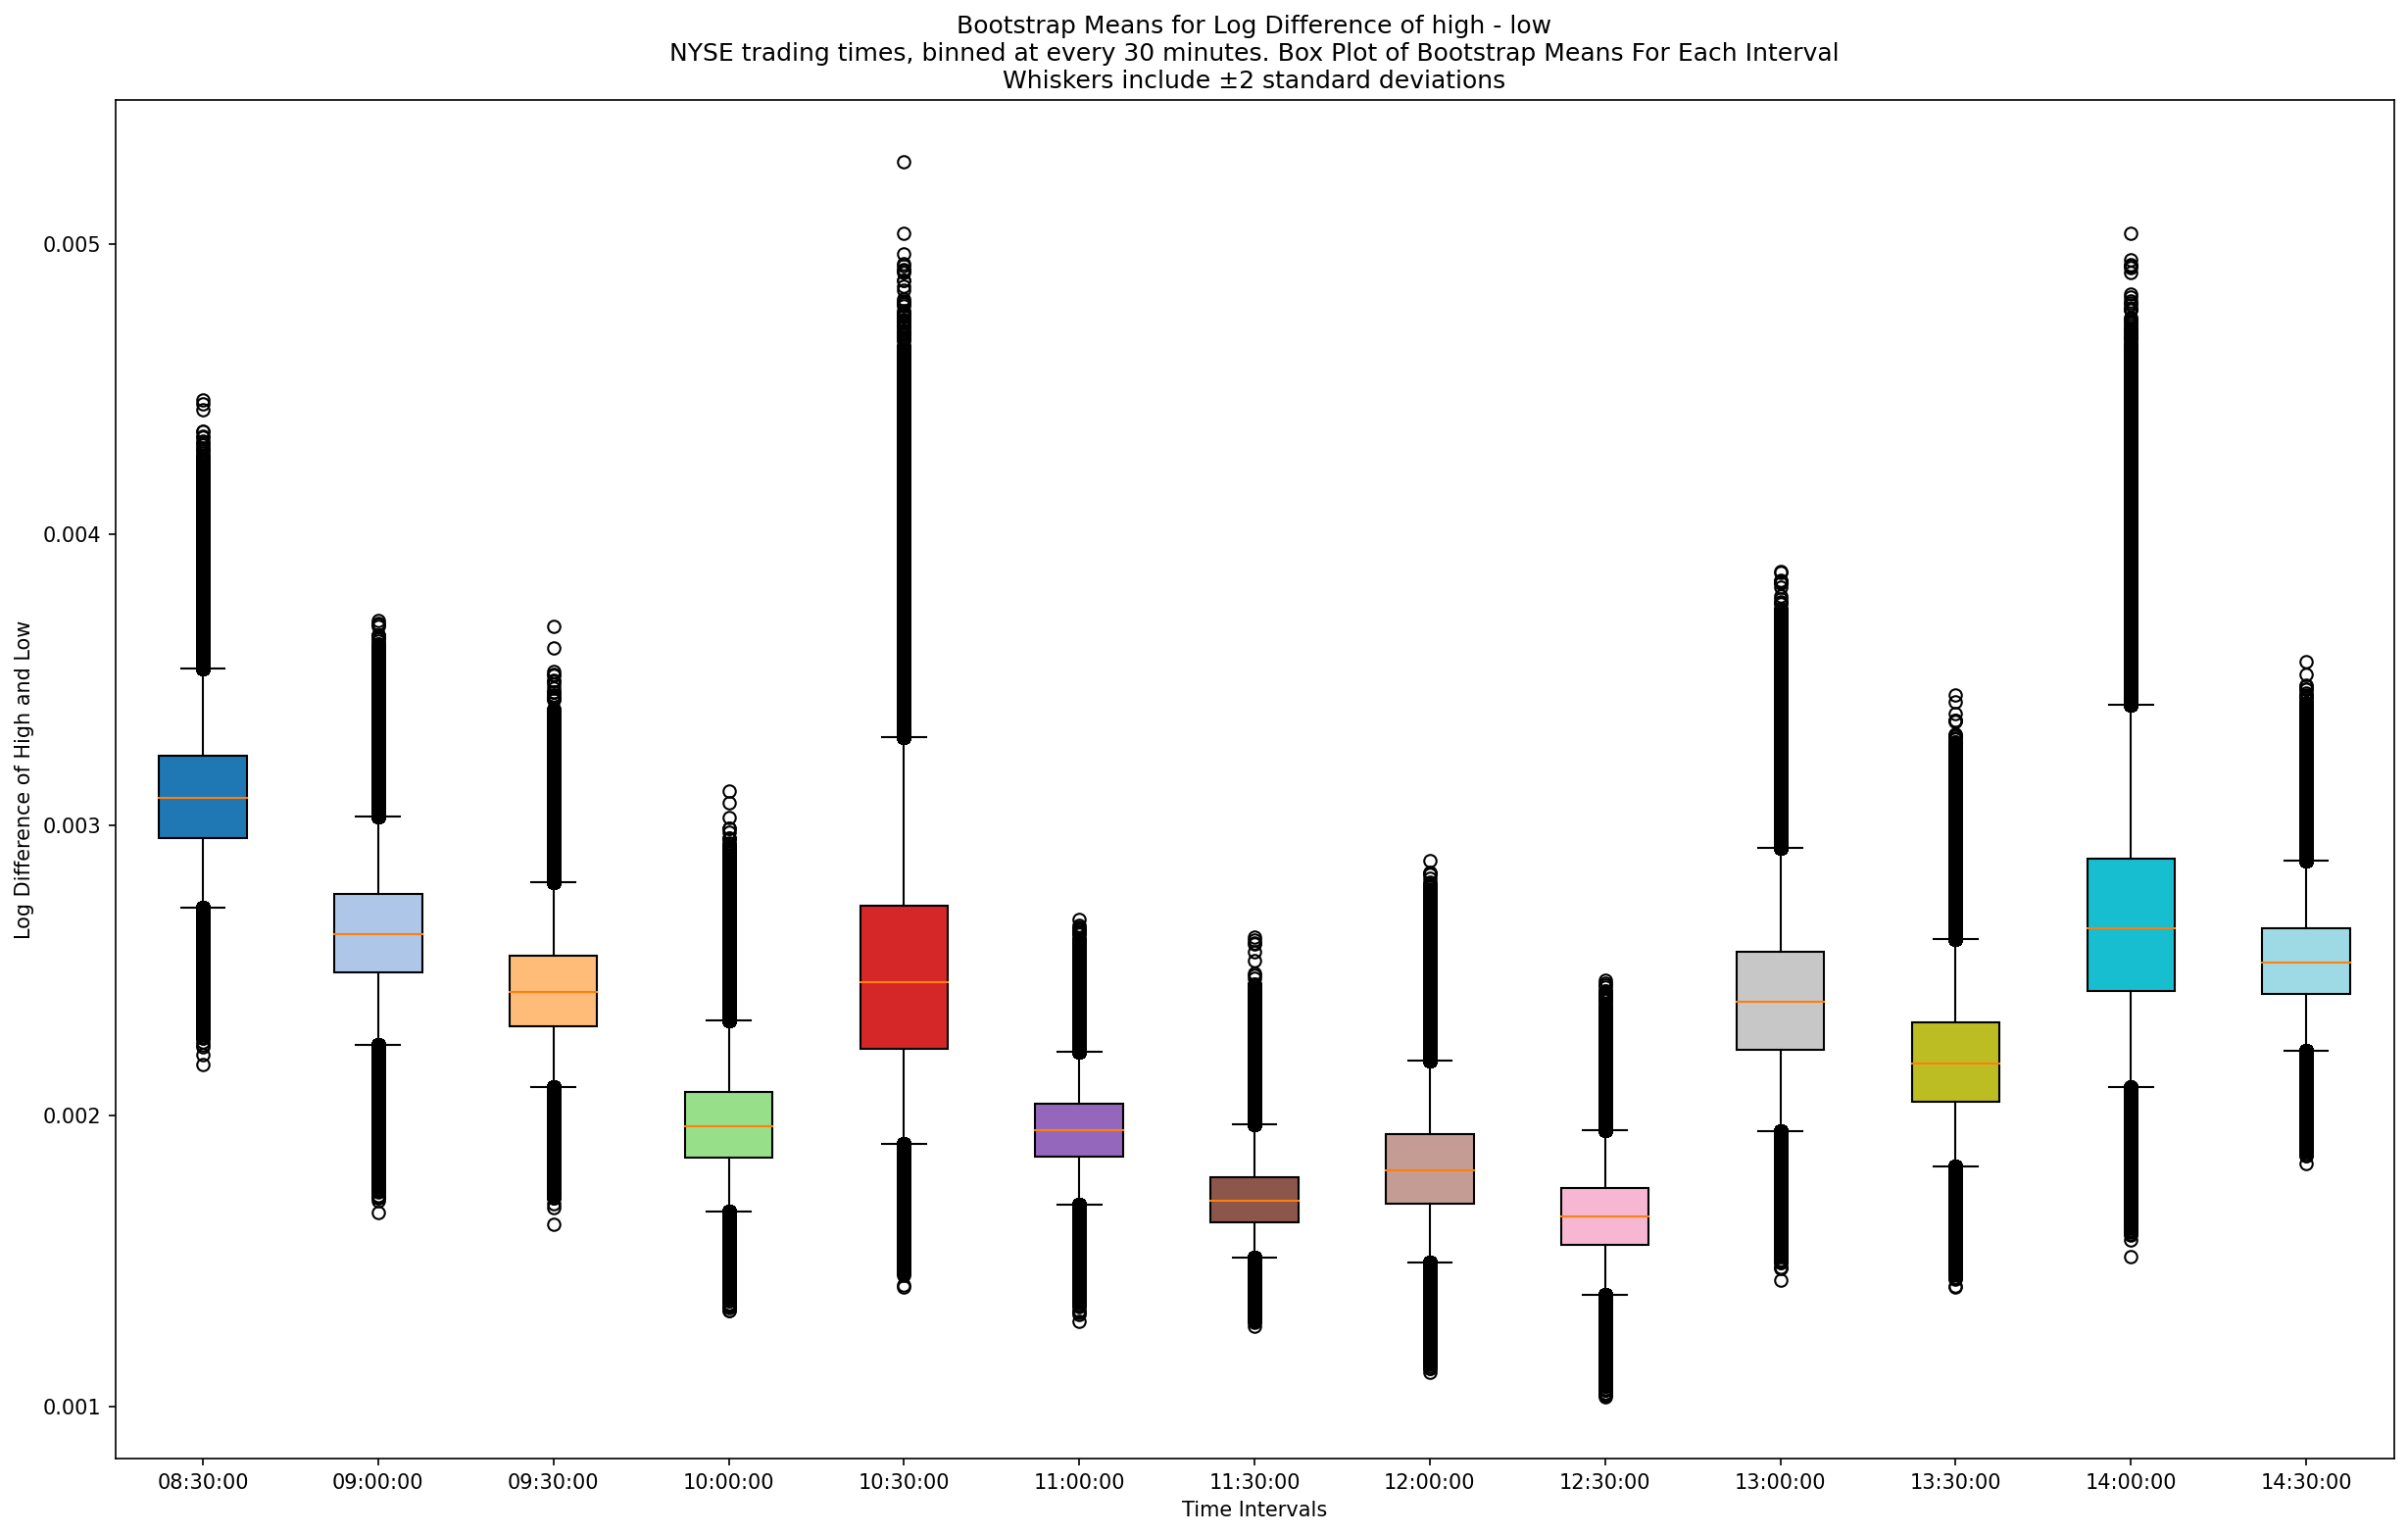

In [18]:
plt.figure(figsize=(20, 12))

boxplot = plt.boxplot(bootstrapped_time_grouped_df["ResampledData"], labels=bootstrapped_time_grouped_df["Time"], patch_artist=True, boxprops=dict(facecolor='gray'), showfliers=True, whis=(2.5, 97.5))

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Bootstrap Means for Log Difference of high - low\nNYSE trading times, binned at every 30 minutes. Box Plot of Bootstrap Means For Each Interval\nWhiskers include ±2 standard deviations")
plt.xlabel("Time Intervals")
plt.ylabel("Log Difference of High and Low")
plt.show()

### Rankings of the 30-minute intervals
The scores are ranked from highest (most volatility) to lowest (least volatility). The scores are mostly weighted by their mean but are punished by a larger coefficient of variation (mean/stddev ratio). The Coefficient of variation only is significant when the intervals are lower ranked. The intuition behind this ranking metric is that we want to be confident that, on average, the volatility within that interval is true to its average (due to punishing the interval for having a wider variance).

In [19]:
CoeffOfVar = (time_stddev / time_mean)*10
time_mean *= 1000

data_score = time_mean**4 - CoeffOfVar*2 # custom ranking metric...prioritize mean but punish by larger standard deviations

data = list(zip(Times, data_score)) # combine Time labels and the scores
sorted_data = sorted(data, key=lambda x: x[1], reverse=True) # sort from highest to lowest

print("Time\t   Score")
for time, score in sorted_data:
    print(f"{time} - {score:.2f}")

Time	   Score
08:30:00 - 85.08
09:00:00 - 39.38
14:00:00 - 37.13
14:30:00 - 33.98
09:30:00 - 26.82
10:30:00 - 22.90
13:00:00 - 21.89
13:30:00 - 12.94
11:00:00 - 6.99
10:00:00 - 5.85
11:30:00 - 1.15
12:00:00 - 0.31
12:30:00 - -2.06


# Decay of scores
For visual purposes, let's see what decay of the sorted scores. This will help visualize the rapid decay of volatility as the intervals are lower ranked.

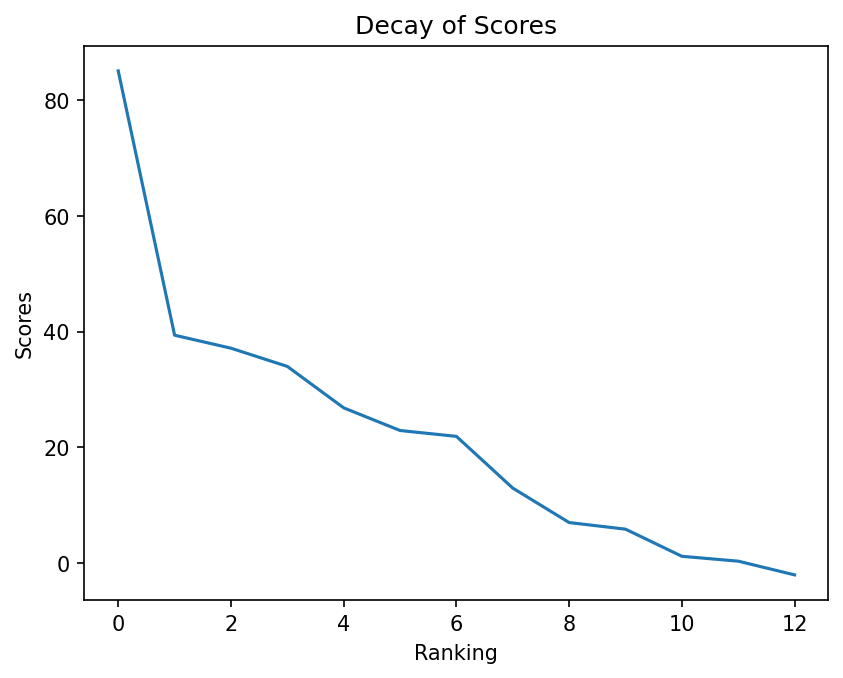

In [20]:
sorted_scores = [item[1] for item in sorted_data]
plt.plot(sorted_scores)
plt.title("Decay of Scores")
plt.ylabel("Scores")
plt.xlabel("Ranking")
plt.show()

# Last updated: June 28, 2023